# Data analysis for the snowmelt modeling use cases



### 1. Retrieve data from HydroShare

In [1]:
import os, hs_restclient
from zipfile import ZipFile

# initiate functions from hs_restclient
hs=hs_restclient.HydroShare()

# initiate a data analysis folder
os.mkdir('data_analysis')
os.chdir('data_analysis')

# download model output zip files from HydroShare
case1_path =hs.getResourceFile('1be4d7902c87481d85b93daad99cf471', '20171010_234034_output_package.zip', destination=os.getcwd())
case2_path =hs.getResourceFile('a2b87a2f25d046958ac604e522f449c0', '20190415_235822_output_package.zip', destination=os.getcwd())

# unzip downloaded files
data_dir_list = []
for file_path in [case1_path, case2_path]:
    data_dir = file_path.replace('.zip','')
    os.mkdir(data_dir)
    with ZipFile(file_path,'r') as zip_f:
         zip_f.extractall(data_dir)
    data_dir_list.append(data_dir)

### 2. Compare domain average SWE and SWIT (surface water total input)

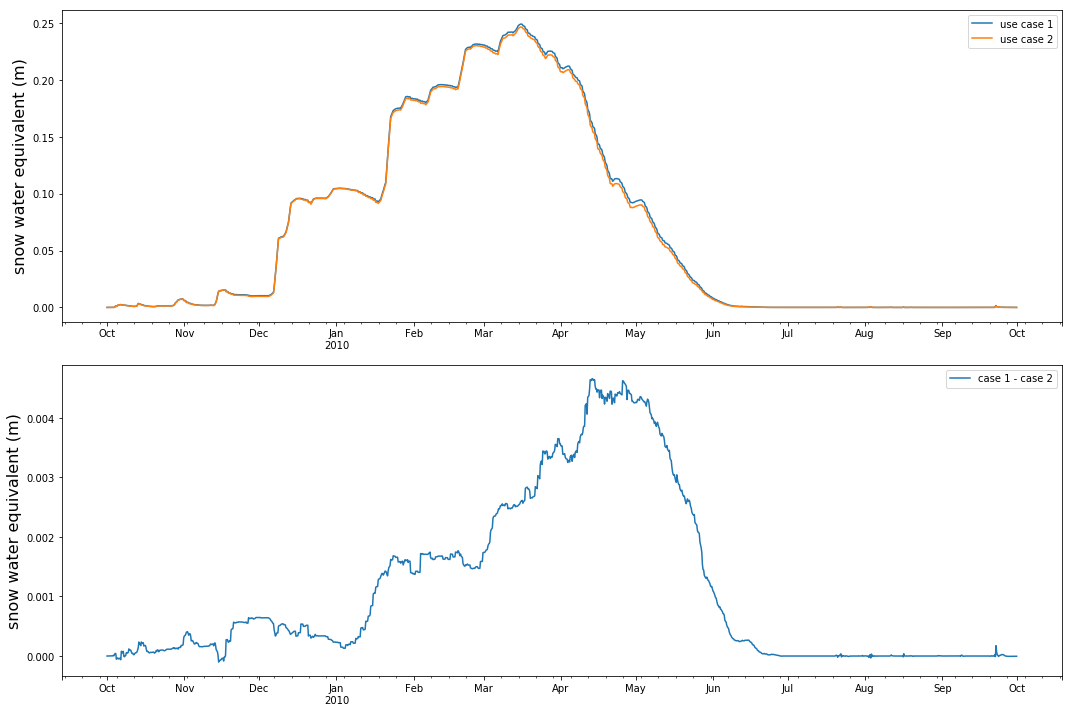

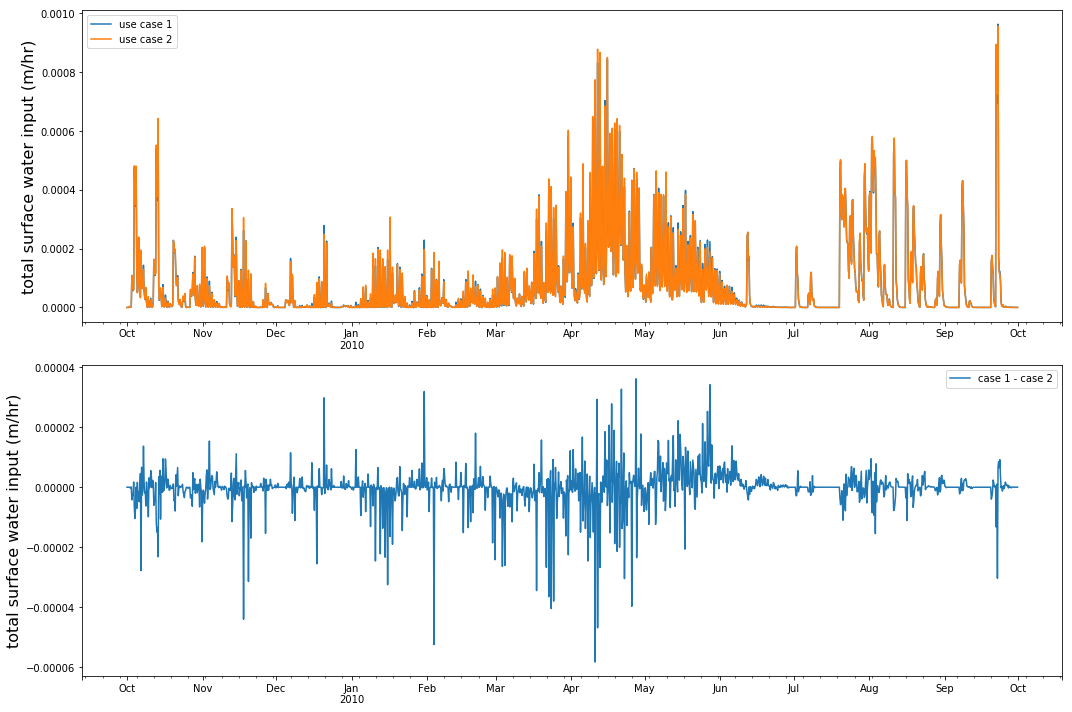

In [9]:
import netCDF4
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# read aggout.nc file (domain average data)
case1_data = netCDF4. Dataset(os.path.join(data_dir_list[0],'aggout.nc'),'r')
case2_data = netCDF4. Dataset(os.path.join(data_dir_list[1],'aggout.nc'),'r')

# retrieve time data
time = case1_data.variables['time']
time_data = time[:]
time_units = getattr(time, 'units', None)
time_calendar = getattr(time, 'calendar', None)
time_var = [netCDF4.num2date(value, units=time_units, calendar=time_calendar) for value in time_data]

# compare model output of snow water equivalent and total surface water input
for variable, name, units in zip(['SWE','SWIT'],['snow water equivalent','total surface water input'],['(m)','(m/hr)']):
    # retrieve domain average varabile data
    case1_var = numpy.squeeze(case1_data.variables[variable][:])
    case2_var = numpy.squeeze(case2_data.variables[variable][:])
    var_diff = case1_var - case2_var

    # make plot for comparison
    plot_data = {'time':time_var, 'use case 1': case1_var, 'use case 2': case2_var, 'case 1 - case 2': var_diff}
    plot_df = pd.DataFrame(plot_data)
    plot_df.set_index('time',inplace=True)
    
    fig, ax = plt.subplots(2,1,figsize=(15,10))
    plot_df.plot(y=['use case 1','use case 2'], ax=ax[0])
    plot_df.plot(y=['case 1 - case 2'], ax=ax[1])
    
    for axis in ax:
        axis.set_ylabel('{} {}'.format(name, units),fontsize=16)
        axis.set_xlabel('')

    plt.tight_layout()
    
case1_data = None
case2_data = None